In [3]:
import datetime 
from tqdm import tqdm

In [4]:
# https://arxiv.org/abs/1806.01768
# https://arxiv.org/abs/1910.02600

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [5]:
from sklearn.metrics import roc_auc_score, accuracy_score

In [6]:
print(torch.__version__) # Get PyTorch and CUDA version
print(f"{torch.cuda.is_available() = }") # Check that CUDA works
print(f"{torch.cuda.device_count() = }") # Check how many CUDA capable devices you have
# Print device human readable names
print(f"{torch.cuda.get_device_name(0) = }")
# Add more lines with +1 like get_device_name(3), get_device_name(4) if you have more devices.

2.0.1
torch.cuda.is_available() = True
torch.cuda.device_count() = 1
torch.cuda.get_device_name(0) = 'NVIDIA T1200 Laptop GPU'


In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(0)

## Create the MLP Model

In [155]:
class clf_model(nn.Module):
    def __init__(self, units:list, n_classes:int = 10):
        super().__init__()
        self.units = units
        self.n_layers = len(self.units)
        self.n_classes = n_classes
        self.output = nn.Softmax(dim=1)
        
        # layers
        self.layers = nn.ModuleList()
        self.get_layers()
        ## loss
        self.cross_entropy_loss = nn.CrossEntropyLoss()

        print(f'Model Intialized: {self}')


    def forward(self, x):
        
        for layer in self.layers:
            x = layer(x)

        x = self.output(x)

        return x

    def loss(self, pred, label):
        loss = self.cross_entropy_loss(pred, label)
        return loss
    
    def get_layers(self):

        for i in range(len(self.units)-1):
            layer = nn.Linear(self.units[i], self.units[i+1])
            self.layers.append(layer)
        
        layer = nn.Linear(self.units[-1], self.n_classes)
        self.layers.append(layer)

### Test Model

In [113]:
model = clf_model(units = [28*28, 45, 30], n_classes = 10).to(device)
model

Model Intialized: clf_model(
  (output): Softmax(dim=1)
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=45, bias=True)
    (1): Linear(in_features=45, out_features=30, bias=True)
    (2): Linear(in_features=30, out_features=10, bias=True)
  )
  (cross_entropy_loss): CrossEntropyLoss()
)


clf_model(
  (output): Softmax(dim=1)
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=45, bias=True)
    (1): Linear(in_features=45, out_features=30, bias=True)
    (2): Linear(in_features=30, out_features=10, bias=True)
  )
  (cross_entropy_loss): CrossEntropyLoss()
)

In [114]:
temp_x = np.random.random(size=(12,28*28))
temp_x = torch.FloatTensor(temp_x).to(device)
print(f'Tensor Shape = {temp_x.shape}')
print(f'Tensor Device = {temp_x.device}')

Tensor Shape = torch.Size([12, 784])
Tensor Device = cuda:0


In [115]:
temp_lbl = np.random.randint(0, 9, size = 12)
temp_lbl = torch.LongTensor(temp_lbl).to(device)
print(f'Tensor Shape = {temp_lbl.shape}')
print(f'Tensor Device = {temp_lbl.device}')

Tensor Shape = torch.Size([12])
Tensor Device = cuda:0


In [116]:
pred = model.forward(temp_x)
print(f'Shape of predictions  = {pred.shape}')

Shape of predictions  = torch.Size([12, 10])


In [117]:
model.loss(pred, temp_lbl)

tensor(2.3059, device='cuda:0', grad_fn=<NllLossBackward0>)

## Create Dataloader

In [118]:
class MNIST():

    def __init__(self, input_path:str):
        self.df = pd.read_csv(input_path)
        print(f'Loaded data, {self.df.shape[0]} samples')
        self.labels = self.get_label()
        self.inputs = self.get_input()
        self.normalize_inputs()
        print('Loaded input data')
        print(f'Input data shape = {self.inputs.shape}')
        print(f'Output data shape = {self.labels.shape}')
        self.df = None

    def get_label(self):
        return self.df['label'].values
    
    def get_input(self):
        columns = self.df.columns.tolist()
        columns.remove('label')
        return self.df[columns].values

    def normalize_inputs(self):
        self.inputs = self.inputs/255
      
        

In [119]:
class MNISTLoader(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
        self.labels = self.data.labels
        self.inputs = self.data.inputs
        self.n_samples = self.inputs.shape[0]
        self.input_dim = self.inputs.shape[1]
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, index):

        x = self.inputs[index]
        y = self.labels[index]
        return torch.FloatTensor(x), y
    
    @staticmethod
    def collate():
        pass



In [120]:
data_path = '../data/mnist/raw/mnist_train.csv'
data = MNIST(data_path)

Loaded data, 60000 samples
Loaded input data
Input data shape = (60000, 784)
Output data shape = (60000,)


In [121]:
dataset = MNISTLoader(data)

In [122]:
test_data_path = '../data/mnist/raw/mnist_test.csv'
test_data = MNIST(test_data_path)

Loaded data, 10000 samples
Loaded input data
Input data shape = (10000, 784)
Output data shape = (10000,)


In [123]:
dataset[0][0]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [162]:
batch_size = 64
shuffle = True
epochs = 5
initial_lr = 0.01
units = [data.inputs.shape[1], 30]

In [163]:
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)

In [164]:
for i, batch in enumerate(dataloader):
    print(f'Batch type - {type(batch)}')
    print(batch[0].shape)
    print(batch[1].shape)
    break

Batch type - <class 'list'>
torch.Size([64, 784])
torch.Size([64])


## Train the Model

In [165]:
test_inputs = test_data.inputs
test_labels = test_data.labels

In [166]:
clf = clf_model(units=units).to(device)

Model Intialized: clf_model(
  (output): Softmax(dim=1)
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=10, bias=True)
  )
  (cross_entropy_loss): CrossEntropyLoss()
)


In [167]:
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)

In [168]:
optimizer = optim.Adam(clf.parameters(), lr=initial_lr)

In [169]:
len(dataloader)

938

In [170]:
%time
results = []
start_time = datetime.datetime.now()
for epoch in range(epochs):
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, len(dataloader))
    running_loss = 0
    
    for i, batches in tqdm(enumerate(dataloader)):
        input = batches[0].to(device)
        label = batches[1].to(device)

        optimizer.zero_grad()

        pred = clf.forward(input)
        loss = clf.loss(pred, label)
        loss.backward()
        optimizer.step()

        scheduler.step()
        running_loss += loss.item()

        if (i > 0) and (i%200 == 0):
            with torch.no_grad():
                pred = clf.forward(torch.FloatTensor(test_inputs).to(device))
                pred = pred.detach().cpu().numpy()
                pred = np.argmax(pred, axis=1)
                accuracy = accuracy_score(test_labels, pred)
                # roc_auc = roc_auc_score(test_labels, pred)
            print("Epoch: {}, Seq: {:,}/{:,}, " \
                "Loss: {:.4f}, ACCURACY : {:.4f}, Lr: {:.6f}".format(epoch, i, len(dataloader), running_loss,
                                                                        accuracy, optimizer.param_groups[0]['lr']))
            results.append([epoch, i, running_loss, accuracy])
            running_loss = 0


end_time = datetime.datetime.now()  

CPU times: total: 0 ns
Wall time: 0 ns


223it [00:01, 181.52it/s]

Epoch: 0, Seq: 200/938, Loss: 331.0525, ACCURACY : 0.8930, Lr: 0.008909


437it [00:02, 188.24it/s]

Epoch: 0, Seq: 400/938, Loss: 314.0885, ACCURACY : 0.9103, Lr: 0.006129


631it [00:03, 169.23it/s]

Epoch: 0, Seq: 600/938, Loss: 311.7034, ACCURACY : 0.9155, Lr: 0.002861


820it [00:04, 170.22it/s]

Epoch: 0, Seq: 800/938, Loss: 309.8457, ACCURACY : 0.9210, Lr: 0.000517


938it [00:05, 177.65it/s]
237it [00:01, 178.14it/s]

Epoch: 1, Seq: 200/938, Loss: 315.0016, ACCURACY : 0.9030, Lr: 0.008909


421it [00:02, 177.84it/s]

Epoch: 1, Seq: 400/938, Loss: 313.1842, ACCURACY : 0.9053, Lr: 0.006129


634it [00:03, 183.35it/s]

Epoch: 1, Seq: 600/938, Loss: 310.7623, ACCURACY : 0.9188, Lr: 0.002861


825it [00:04, 189.18it/s]

Epoch: 1, Seq: 800/938, Loss: 309.1788, ACCURACY : 0.9226, Lr: 0.000517


938it [00:04, 189.39it/s]
237it [00:01, 179.50it/s]

Epoch: 2, Seq: 200/938, Loss: 313.8687, ACCURACY : 0.9121, Lr: 0.008909


425it [00:02, 186.42it/s]

Epoch: 2, Seq: 400/938, Loss: 311.8864, ACCURACY : 0.9092, Lr: 0.006129


641it [00:03, 192.90it/s]

Epoch: 2, Seq: 600/938, Loss: 310.2259, ACCURACY : 0.9212, Lr: 0.002861


824it [00:04, 177.07it/s]

Epoch: 2, Seq: 800/938, Loss: 308.1536, ACCURACY : 0.9237, Lr: 0.000517


938it [00:04, 188.13it/s]
225it [00:01, 190.38it/s]

Epoch: 3, Seq: 200/938, Loss: 313.1513, ACCURACY : 0.9118, Lr: 0.008909


441it [00:02, 180.49it/s]

Epoch: 3, Seq: 400/938, Loss: 311.8642, ACCURACY : 0.9176, Lr: 0.006129


623it [00:03, 172.11it/s]

Epoch: 3, Seq: 600/938, Loss: 308.1946, ACCURACY : 0.9218, Lr: 0.002861


827it [00:04, 178.01it/s]

Epoch: 3, Seq: 800/938, Loss: 308.6600, ACCURACY : 0.9265, Lr: 0.000517


938it [00:05, 185.20it/s]
239it [00:01, 182.13it/s]

Epoch: 4, Seq: 200/938, Loss: 312.3098, ACCURACY : 0.8973, Lr: 0.008909


434it [00:02, 189.31it/s]

Epoch: 4, Seq: 400/938, Loss: 310.6495, ACCURACY : 0.9161, Lr: 0.006129


626it [00:03, 173.71it/s]

Epoch: 4, Seq: 600/938, Loss: 310.5061, ACCURACY : 0.9207, Lr: 0.002861


839it [00:04, 188.34it/s]

Epoch: 4, Seq: 800/938, Loss: 308.1838, ACCURACY : 0.9238, Lr: 0.000517


938it [00:04, 197.22it/s]


## Check model's robustness to change in Data Distribution

In [61]:
def rotate_img(x, deg):
    import scipy.ndimage as nd
    return nd.rotate(x.reshape(28,28),deg,reshape=False).ravel()

In [96]:
28*28

784

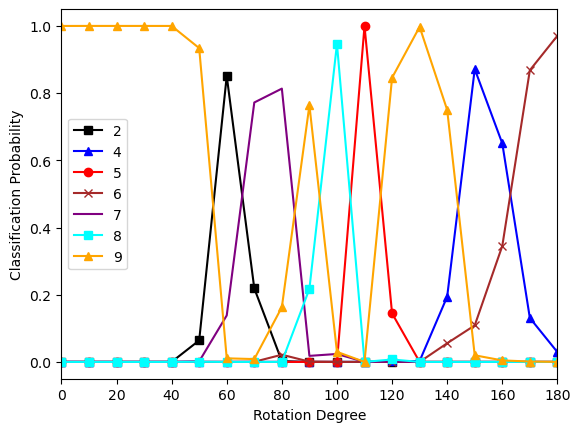

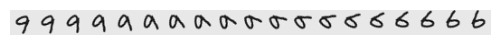

In [111]:
idx = np.where(test_labels == 9)[0][5]
img = test_inputs[idx]
K = 10
Mdeg = 180 
Ndeg = int(Mdeg/10)+1
ldeg = []
lp = []
lu=[]
threshold = 0.5
scores = np.zeros((1,K))
rimgs = np.zeros((28,28*Ndeg))
for i,deg in enumerate(np.linspace(0,Mdeg, Ndeg)):
    nimg = rotate_img(img,deg)
    p_pred_t = clf.forward(torch.FloatTensor(np.expand_dims(nimg, 0)).to(device))
    p_pred_t = p_pred_t.detach().cpu().numpy()
    scores += p_pred_t >= threshold
    ldeg.append(deg)
    lp.append(p_pred_t[0])
    nimg = nimg.reshape(28,28)
    rimgs[:,i*28:(i+1)*28] = nimg

labels = np.arange(10)[scores[0].astype(bool)]
lp = np.array(lp)[:,labels]
c = ['black','blue','red','brown','purple','cyan', 'orange']
marker = ['s','^','o', 'x', '']*2
labels = labels.tolist()
for i in range(len(labels)):
    plt.plot(ldeg,lp[:,i],marker=marker[i],c=c[i])
plt.legend(labels)

plt.xlim([0,Mdeg])  
plt.xlabel('Rotation Degree')
plt.ylabel('Classification Probability')
plt.show()

plt.figure(figsize=[6.2,100])
plt.imshow(1-rimgs,cmap='gray')
plt.axis('off')
plt.show()

## Create the EDL Model

In [ ]:
class edl_clf_model(nn.Module):
    def __init__(self, units:list, n_classes:int = 10):
        super().__init__()
        self.units = units
        self.n_layers = len(self.units)
        self.n_classes = n_classes
        # self.output = nn.Softmax(dim=1)
        self.output = self.DenseDirichlet()
        
        # layers
        self.layers = nn.ModuleList()
        self.get_layers()
        ## loss
        self.cross_entropy_loss = nn.CrossEntropyLoss()

        print(f'Model Intialized: {self}')


    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        

        x = self.output(x)

        return x

    def loss(self, pred, label):
        loss = self.cross_entropy_loss(pred, label)
        return loss
    
    def get_layers(self):

        for i in range(len(self.units)-1):
            layer = nn.Linear(self.units[i], self.units[i+1])
            self.layers.append(layer)
        
        layer = nn.Linear(self.units[-1], self.n_classes)
        self.layers.append(layer)